In [1]:
from dotenv import load_dotenv
import os
load_dotenv(".env")
from IPython.display import Image, display

In [2]:
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, AIMessage
from langchain.tools import tool
import datetime
import random
from typing import Dict, List, Optional, Union

In [3]:
from typing_extensions import TypedDict

class AgentState(TypedDict):
    user_input: Optional[str]  # Voice/text input from user
    agent_response: Optional[str]  # Response from agents
    context: Dict  # User context (preferences, consent, history)
    red_flag: bool  # For wellness/social checks
    daily_summary: Optional[str]  # For daily reports
    session_id: str  # Unique session identifier
    last_reminder_type: Optional[str]  # Track last proactive reminder
    
# Initialize LLM (Gemini 2.0 Flash)
try:
    llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", api_key=os.getenv("GEMINI_API_KEY"))
except Exception as e:
    raise ValueError(f"Failed to initialize LLM: {e}")

# In-memory data (replacing MongoDB)
USER_PREFERENCES = {}  # {user_id: {"orders": True, "videos": True, ...}}
USER_CONSENT = {}  # {user_id: {"share_phi": True, "approver": "Ted", ...}}
RESOURCES = [
    {"title": "Neighborhood Health Fair", "content": "Event on Saturday at 10 AM"},
    {"title": "COVID Clinic", "content": "Free flu shots available"},
]
VIDEOS = [
    {"title": "Yoga for Beginners", "url": "video1.mp4", "duration": 300, "therapy": False},
    {"title": "Therapy Session", "url": "video2.mp4", "duration": 300, "therapy": True},
]
CLASSES = [
    {"title": "Morning Yoga", "time": "9 AM", "location": "Online"},
    {"title": "Fitness Bootcamp", "time": "6 PM", "location": "Gym"},
]
VENDORS = ["doordash", "lyft", "cvs", "amazon"]

In [4]:
# Tools for agents
@tool
def send_alert(recipient: str, message: str, user_id: str = "Jane") -> str:
    """Send an alert to a recipient (e.g., CNA, family, office)."""
    if not recipient or not message:
        raise ValueError("Recipient and message are required.")
    approver = USER_CONSENT.get(user_id, {}).get("approver", "Ted")
    print(f"Alert to {recipient} ({approver if recipient == 'Family' else ''}): {message}")
    return f"Alert sent to {recipient} about {user_id}: {message}"

@tool
def generate_question(category: str = "wellness") -> str:
    """Generate a wellness, social, or other question based on category."""
    wellness_questions = [
        "How are you feeling today? Any symptoms like fever or pain?",
        "Did you sleep well last night? Any issues?",
    ]
    social_questions = [
        "How’s your mood today? Want to chat?",
        "Feeling lonely? I’m here to talk!",
    ]
    video_questions = ["Would you like to watch a video, like Yoga for Beginners?"]
    class_questions = ["Can I find you some activities, like Morning Yoga?"]
    resource_questions = ["There’s a COVID clinic Saturday. Want to go?"]

    questions = {
        "wellness": wellness_questions,
        "social": social_questions,
        "video": video_questions,
        "class": class_questions,
        "resource": resource_questions,
    }
    return random.choice(questions.get(category, wellness_questions))

@tool
def semantic_search(query: str) -> List[Dict]:
    """Perform semantic search on in-memory resources."""
    if not query or not isinstance(query, str):
        raise ValueError("Valid query string required for search.")
    return [
        resource for resource in RESOURCES
        if query.lower() in resource["title"].lower() or query.lower() in resource["content"].lower()
    ][:3]  # Top 3 results

@tool
def process_order(product: str, vendor: str, user_id: str = "Jane") -> str:
    """Process an order from a vendor with family approval if needed."""
    if not product or not vendor or vendor.lower() not in VENDORS:
        raise ValueError("Valid product and vendor (DoorDash, Lyft, CVS, Amazon) required.")
    
    consent = USER_CONSENT.get(user_id, {})
    if consent.get("share_phi", False) and consent.get("approver"):
        approval = input(f"Family approval required for {product} from {vendor}. Approve? (yes/no): ").lower()
        if approval != "yes":
            return "Order cancelled: Family approval not granted."
    
    status = f"Order placed for {product} from {vendor}. Tracking pending..."
    send_alert("Family", f"Order status for {user_id}: {status}", user_id)
    return status

@tool
def book_class(class_title: str, user_id: str = "Jane") -> str:
    """Book a class based on title and user preferences."""
    if not class_title:
        raise ValueError("Class title required for booking.")
    class_found = next((c for c in CLASSES if class_title.lower() in c["title"].lower()), None)
    if not class_found:
        return "Class not found. Try another title."
    
    send_alert("Family", f"{user_id} enrolled in {class_title} at {class_found['time']}", user_id)
    return f"Enrolled in {class_title} at {class_found['time']}. Reminder set!"

@tool
def play_video(video_title: str, user_id: str = "Jane") -> str:
    """Recommend and play a video, tracking completion for therapy videos."""
    if not video_title:
        raise ValueError("Video title required.")
    video = next((v for v in VIDEOS if video_title.lower() in v["title"].lower()), None)
    if not video:
        return "Video not found. Try another title."
    
    if video["therapy"]:
        print(f"Playing therapy video '{video_title}' for {user_id} with 30s countdown...")
    else:
        print(f"Playing video '{video_title}' for {user_id}...")
    
    USER_PREFERENCES.setdefault(user_id, {}).update({"videos_watched": [video["title"]]})
    return f"Playing '{video_title}'. {'Therapy video - 30s mandatory viewing' if video['therapy'] else 'Enjoy!'}"

In [ ]:
# Agent nodes (returning dictionaries or strings for LangGraph)
def master_agent(state: Dict) -> Union[str, Dict]:
    """Master Agent routes queries to specialized agents using Gemini 2.0 Flash."""
    user_input = state.get("user_input")
    if not user_input:
        # Handle proactive reminders (e.g., daily wellness check at 9 AM)
        now = datetime.datetime.now()
        if now.hour == 9 and not state.get("last_reminder_type"):
            return {
                "agent_response": generate_question("wellness"),
                "last_reminder_type": "wellness"
            }, "wellness_agent"
        return END
    
    try:
        user_input = user_input.lower().strip()
        message = HumanMessage(content=user_input)
        response = llm.invoke([message]).content or "Sorry, I didn’t understand. Can you clarify?"
        
        # Keyword-based intent detection
        intents = {
            "order_agent": ["order", "buy", "purchase"],
            "video_agent": ["video", "watch", "lesson"],
            "class_agent": ["class", "activity", "group"],
            "wellness_agent": ["wellness", "health", "feeling", "check-up"],
           
        }
        
        for agent, keywords in intents.items():
            if any(keyword in user_input for keyword in keywords):
                state["context"]["history"].append({"input": user_input, "intent": agent})
                return agent
        
        return {"agent_response": response}
    
    except Exception as e:
        return {"agent_response": f"Error processing request: {str(e)}"}

def wellness_agent(state: Dict) -> Union[str, Dict]:
    """Conduct wellness checks, detect red flags, and alert CNA/family."""
    user_input = state.get("user_input")
    try:
        if not user_input:  # Proactive reminder
            return {
                "agent_response": f"Hi Jane, {generate_question('wellness')}",
                "last_reminder_type": "wellness"
            }, "wait_for_user_response"
        
        response = user_input.lower()
        red_flags = ["not well", "ill", "fever", "pain", "sick", "unwell", "suicide", "depressed"]
        red_flag = any(flag in response for flag in red_flags)
        
        if red_flag:
            consent = USER_CONSENT.get("Jane", {}).get("share_phi", False)
            if consent:
                send_alert("CNA", f"Red flag detected for Jane: {response}", "Jane")
                send_alert("Family", f"Red flag detected for Jane: {response}", "Jane")
                return {"agent_response": "Alert sent to CNA and family. A video call may follow.", "red_flag": True}
            return {"agent_response": "Red flag detected, but PHI sharing not consented. Please contact support.", "red_flag": True}
        else:
            return {"agent_response": generate_question("wellness")}
    
    except Exception as e:
        return {"agent_response": f"Error in wellness check: {str(e)}"}

def order_agent(state: Dict) -> Dict:
    """Handle ordering process with family approval."""
    user_input = state.get("user_input")
    try:
        if "order" not in user_input.lower():
            return {"agent_response": "Please specify what you want to order (e.g., pizza, medicine)."}
        
        parts = user_input.lower().split("order")
        product = parts[1].strip() if len(parts) > 1 else "pizza"
        vendor = random.choice(VENDORS)
        
        result = process_order(product, vendor, "Jane")
        state["context"]["history"].append({"order": product, "vendor": vendor, "result": result})
        return {"agent_response": f"Order Summary: {result}\nValidate on the app screen."}
    
    except Exception as e:
        return {"agent_response": f"Error processing order: {str(e)}"}

def video_agent(state: Dict) -> Union[str, Dict]:
    """Recommend and play videos, tracking completion."""
    user_input = state.get("user_input")
    try:
        if "video" not in user_input.lower():
            video = random.choice(VIDEOS)
            return {
                "agent_response": f"Would you like to watch '{video['title']}'? Say 'yes' to play.",
                "last_reminder_type": "video"
            }, "wait_for_user_response"
        
        query = user_input.replace("video", "").strip()
        if "yes" in query:
            video = VIDEOS[0]  # Default to first video for simplicity
            result = play_video(video["title"], "Jane")
            state["context"]["history"].append({"video": query, "action": "played"})
            return {"agent_response": f"Video Screen: {result}\nPlaying for 30s if therapy video."}
        else:
            state["context"]["history"].append({"video": query, "action": "skipped"})
            return {"agent_response": "Okay, let me know if you’d like to watch something else!"}
    
    except Exception as e:
        return {"agent_response": f"Error with video: {str(e)}"}

def class_agent(state: Dict) -> Union[str, Dict]:
    """Assist with class enrollment."""
    user_input = state.get("user_input")
    try:
        if "class" not in user_input.lower():
            class_suggestion = random.choice(CLASSES)
            return {
                "agent_response": f"Can I find you some activities? How about '{class_suggestion['title']}' at {class_suggestion['time']}? Say 'enroll' to join.",
                "last_reminder_type": "class"
            }, "wait_for_user_response"
        
        query = user_input.replace("class", "").strip()
        if "enroll" in query:
            class_title = query.replace("enroll", "").strip() or CLASSES[0]["title"]
            result = book_class(class_title, "Jane")
            state["context"]["history"].append({"class": query, "action": "enrolled"})
            return {"agent_response": f"Class Screen: {result}\nCheck your reminders!"}
        else:
            state["context"]["history"].append({"class": query, "action": "skipped"})
            return {"agent_response": "Okay, let me know if you’d like to enroll later!"}
    
    except Exception as e:
        return {"agent_response": f"Error with class enrollment: {str(e)}"}


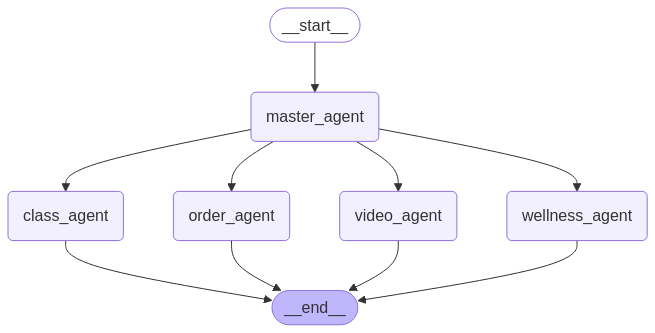

In [8]:
# Build the graph
workflow = StateGraph(AgentState)
# Add nodes
workflow.add_node("master_agent", master_agent)
workflow.add_node("wellness_agent", wellness_agent)
workflow.add_node("order_agent", order_agent)
workflow.add_node("video_agent", video_agent)
workflow.add_node("class_agent", class_agent)

# Add edges (routing)
for agent in ["wellness", "order", "video", "class"]:
    workflow.add_edge("master_agent", f"{agent}_agent")

workflow.add_edge("wellness_agent", END)
workflow.add_edge("video_agent", END)
workflow.add_edge("class_agent", END)
workflow.add_edge("order_agent", END)

# Set entry point
workflow.set_entry_point("master_agent")

# Compile the graph
app = workflow.compile()

display(Image(app.get_graph().draw_mermaid_png()))

In [9]:
# Intake setup (simulated)
def setup_intake(user_id: str = "Jane") -> Dict:
    preferences = {
        "orders": True,
        "videos": True,
        "classes": True,
       
    }
    consent = {
        "share_phi": input("Can we share your PHI? (yes/no): ").lower() == "yes",
        "approver": "Ted",
        "third_parties": input("Report to third parties? (yes/no): ").lower() == "yes",
    }
    USER_PREFERENCES[user_id] = preferences
    USER_CONSENT[user_id] = consent
    initial_state = {
        "context": {"preferences": preferences, "consent": consent, "history": []},
        "session_id": str(random.randint(1, 1000)),
        "last_reminder_type": None,
        "user_input": None,
        "agent_response": None,
        "red_flag": False,
        "daily_summary": None,
    }
    print(f"Intake setup for {user_id}: Preferences={preferences}, Consent={consent}")
    return initial_state

# Example usage
def run_example():
    # Setup intake for Jane
    initial_state = setup_intake("Jane")
    
    # Invoke the graph with the initial state
    result = app.invoke(initial_state)
    print("Initial Response:", result.get("agent_response", "No response"))
    
    # User-initiated interactions
    state = initial_state.copy()
    state["user_input"] = "I want to order a pizza."
    result = app.invoke(state)
    print("Order Response:", result.get("agent_response", "No response"))
    
    state = result  # Update state with the latest result
    state["user_input"] = "Yes, I want to watch a video."
    result = app.invoke(state)
    print("Video Response:", result.get("agent_response", "No response"))
    
    state = result
    state["user_input"] = "Enroll in Morning Yoga."
    result = app.invoke(state)
    print("Class Response:", result.get("agent_response", "No response"))
    
    state = result
    state["user_input"] = "I’m feeling lonely."
    result = app.invoke(state)
    print("Social Response:", result.get("agent_response", "No response"))
    
    state = result
    state["user_input"] = "Can I get a flu shot with COVID?"
    result = app.invoke(state)
    print("Inquiry Response:", result.get("agent_response", "No response"))
    
    # Simulate daily report at 6 PM
    now = datetime.datetime.now()
    if now.hour == 18:  # Simulate 6 PM
        state = result
        state["user_input"] = None  # Trigger report
        result = app.invoke(state)
        print("Daily Report Response:", result.get("agent_response", "No response"))

if __name__ == "__main__":
    run_example()

Intake setup for Jane: Preferences={'orders': True, 'videos': True, 'classes': True}, Consent={'share_phi': True, 'approver': 'Ted', 'third_parties': True}


InvalidUpdateError: Expected dict, got __end__
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_GRAPH_NODE_RETURN_VALUE